## 1. Выбор начальных условий

a) В качестве набора данных будем использовать датасет зёрен кофе с различными степенями прожарки. Практической задачей в данном случае будет выступать автоматизация сортировки кофейных зёрен на производстве. Разработанная модель сможет приносить финансовый эффект путем автоматизации процессов, для которых используется оплачиваемая рабочая сила

б) В качестве основной метрики классификации будем использовать WeightedF1 меру, которая сможет учитывать одновременно как точность определения (Precision), так и полноту (Recall) классов с учетом их распределения.

## 2. Создание бейзлайна и оценка качества

In [15]:
import pandas as pd
import os
import glob
import random
import matplotlib.pyplot as plt

data_dir = '/kaggle/input/coffee-bean-dataset-resized-224-x-224'

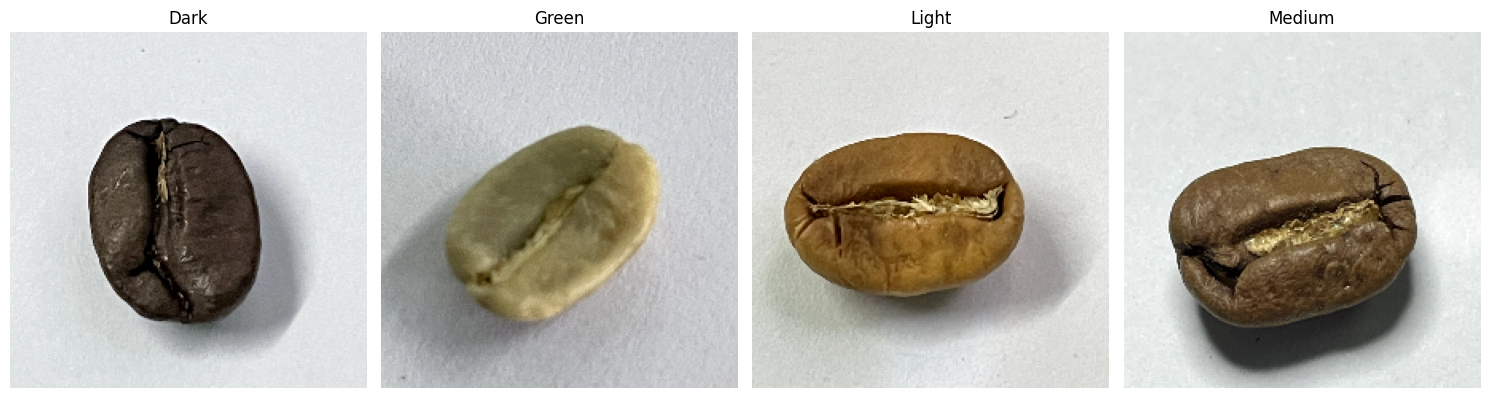

In [42]:
images = []
labels = []
for data_class in ['Dark', 'Green', 'Light', 'Medium']:
    img_paths = glob.glob(os.path.join(data_dir, 'train', data_class, '*.png'))
    if img_paths:
        sample_img = random.choice(img_paths)
        images.append(sample_img)
        labels.append(data_class)

plt.figure(figsize=(15, 5))
for i, (img_path, label) in enumerate(zip(images, labels)):
    plt.subplot(1, 4, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [123]:
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score

baseline_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=baseline_transform)
targets = np.array(full_dataset.targets)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))


train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)


batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4),
}

In [138]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):

    best_f1 = 0.0
    best_preds = []
    best_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_losses = {'train': [], 'val': []}
        epoch_preds = {'train': [], 'val': []}
        epoch_labels = {'train': [], 'val': []}

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_losses[phase].append(loss.detach().cpu().numpy())
                epoch_preds[phase].extend(preds.cpu().numpy())
                epoch_labels[phase].extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = sum(epoch_losses[phase]) / len(epoch_losses[phase])
            epoch_f1   = f1_score(epoch_labels[phase],
                                  epoch_preds[phase],
                                  average='weighted')

            print(f'{phase:5} | Loss: {epoch_loss:.4f}  '
                  f'F1:  {epoch_f1:.4f}')

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = epoch_preds['val'].copy()
                best_labels = epoch_labels['val'].copy()

        print()

    model.load_state_dict(best_model_wts)
    return model, best_preds, best_labels

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

convolutional_model = models.resnet50(pretrained=True)
convolutional_model.fc = nn.Linear(convolutional_model.fc.in_features, 4)
convolutional_model = convolutional_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convolutional_model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

convolutional_model, preds, true_labels = train_model(convolutional_model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation F1 Score: {val_f1:.4f}')

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train | Loss: 1.4247  F1:  0.1268
val   | Loss: 1.4042  F1:  0.1058

Epoch 2/10
----------
train | Loss: 1.3885  F1:  0.1822
val   | Loss: 1.3809  F1:  0.1772

Epoch 3/10
----------
train | Loss: 1.3632  F1:  0.2581
val   | Loss: 1.3510  F1:  0.3085

Epoch 4/10
----------
train | Loss: 1.3331  F1:  0.3474
val   | Loss: 1.3419  F1:  0.3773

Epoch 5/10
----------
train | Loss: 1.3184  F1:  0.4062
val   | Loss: 1.3106  F1:  0.3721

Epoch 6/10
----------
train | Loss: 1.2995  F1:  0.4639
val   | Loss: 1.2867  F1:  0.4618

Epoch 7/10
----------
train | Loss: 1.2802  F1:  0.5018
val   | Loss: 1.2694  F1:  0.4984

Epoch 8/10
----------
train | Loss: 1.2632  F1:  0.5061
val   | Loss: 1.2747  F1:  0.5169

Epoch 9/10
----------
train | Loss: 1.2596  F1:  0.5248
val   | Loss: 1.2750  F1:  0.4929

Epoch 10/10
----------
train | Loss: 1.2653  F1:  0.5360
val   | Loss: 1.2722  F1:  0.4815

Validation F1 Score: 0.5169


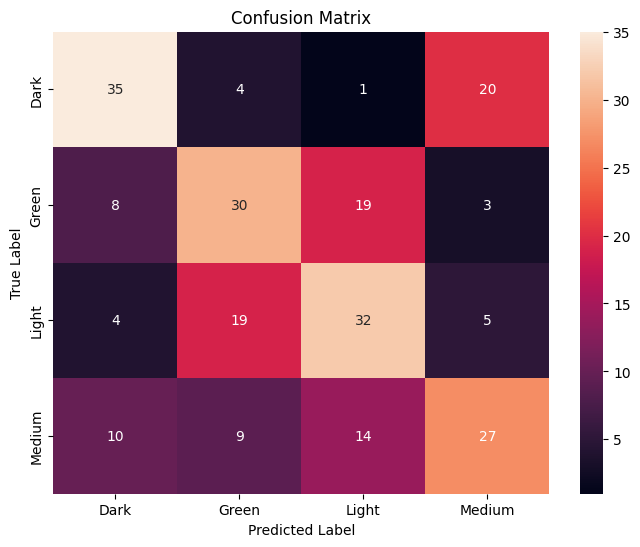

In [154]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [156]:
transformer_model = models.vit_b_16(pretrained=True)
transformer_model.heads.head = nn.Linear(transformer_model.heads.head.in_features, 4)
transformer_model = transformer_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transformer_model.parameters(), lr=3e-5, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

transformer_model, preds, true_labels = train_model(transformer_model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation F1 Score Transform model: {val_f1:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train | Loss: 1.3371  F1:  0.3144
val   | Loss: 1.2180  F1:  0.5050

Epoch 2/10
----------
train | Loss: 1.1464  F1:  0.6288
val   | Loss: 1.0915  F1:  0.6551

Epoch 3/10
----------
train | Loss: 0.9987  F1:  0.7519
val   | Loss: 0.9375  F1:  0.8002

Epoch 4/10
----------
train | Loss: 0.8750  F1:  0.8347
val   | Loss: 0.8328  F1:  0.8171

Epoch 5/10
----------
train | Loss: 0.7677  F1:  0.8811
val   | Loss: 0.7217  F1:  0.8769

Epoch 6/10
----------
train | Loss: 0.6734  F1:  0.9014
val   | Loss: 0.6264  F1:  0.9127

Epoch 7/10
----------
train | Loss: 0.5946  F1:  0.9189
val   | Loss: 0.5407  F1:  0.9254

Epoch 8/10
----------
train | Loss: 0.5434  F1:  0.9382
val   | Loss: 0.5339  F1:  0.9419

Epoch 9/10
----------
train | Loss: 0.5364  F1:  0.9403
val   | Loss: 0.5255  F1:  0.9409

Epoch 10/10
----------
train | Loss: 0.5371  F1:  0.9311
val   | Loss: 0.5271  F1:  0.9496

Validation F1 Score Transform model: 0.9496


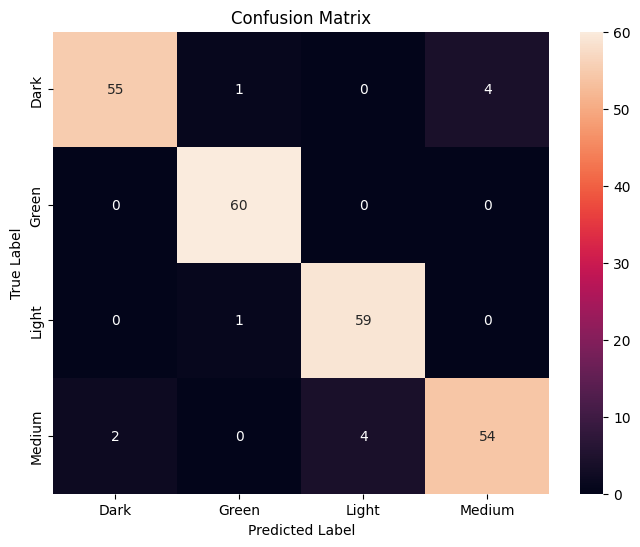

In [157]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 3. Улучшение бейзлайна

Добавим техники аугментации, модель будет лучше обобщать и повысит точность, так как данные станут более разнообразными

In [181]:
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=improved_transforms_train)
val_dataset_full   = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=baseline_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)

In [182]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
}

In [183]:
convolutional_model_improved = models.resnet50(pretrained=True)
convolutional_model_improved.fc = nn.Linear(convolutional_model_improved.fc.in_features, 4)
convolutional_model_improved = convolutional_model_improved.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(convolutional_model_improved.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

convolutional_model_improved, preds_improved, labels_improved = train_model(convolutional_model_improved, criterion, optimizer, scheduler, num_epochs=10)

val_f1_improved = f1_score(labels_improved, preds_improved, average='weighted')
print(f'Validation F1 Score (Improved): {val_f1_improved:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train | Loss: 0.4232  F1:  0.8387
val   | Loss: 0.2208  F1:  0.9415

Epoch 2/10
----------
train | Loss: 0.2133  F1:  0.9251
val   | Loss: 0.2178  F1:  0.9295

Epoch 3/10
----------
train | Loss: 0.2259  F1:  0.9200
val   | Loss: 0.0475  F1:  0.9792

Epoch 4/10
----------
train | Loss: 0.1753  F1:  0.9364
val   | Loss: 0.0868  F1:  0.9625

Epoch 5/10
----------
train | Loss: 0.1159  F1:  0.9583
val   | Loss: 0.1093  F1:  0.9539

Epoch 6/10
----------
train | Loss: 0.1176  F1:  0.9573
val   | Loss: 0.1039  F1:  0.9661

Epoch 7/10
----------
train | Loss: 0.1111  F1:  0.9677
val   | Loss: 0.0508  F1:  0.9751

Epoch 8/10
----------
train | Loss: 0.0957  F1:  0.9697
val   | Loss: 0.0256  F1:  0.9833

Epoch 9/10
----------
train | Loss: 0.0680  F1:  0.9823
val   | Loss: 0.0266  F1:  0.9958

Epoch 10/10
----------
train | Loss: 0.0643  F1:  0.9771
val   | Loss: 0.0324  F1:  0.9917

Validation F1 Score (Improved): 0.9958


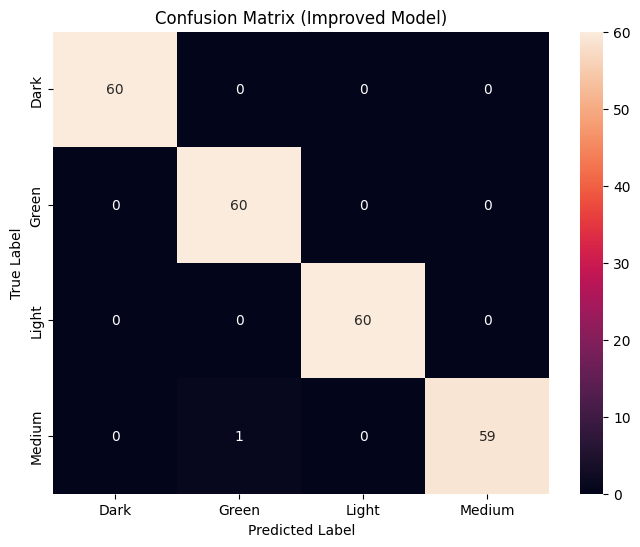

In [184]:
cm = confusion_matrix(labels_improved, preds_improved)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Improved Model)')
plt.show()

In [199]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, 4)
model_vit = model_vit.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(), lr=3e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

improved_model_vit, preds_vit, labels_vit = train_model(model_vit, criterion_vit, optimizer, scheduler, num_epochs=10)

f1_vit  = f1_score(labels_vit, preds_vit, average='weighted')
print(f'Validation F1 Score   (ViT): {f1_vit:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train | Loss: 0.5001  F1:  0.8172
val   | Loss: 0.0962  F1:  0.9667

Epoch 2/10
----------
train | Loss: 0.0928  F1:  0.9677
val   | Loss: 0.0748  F1:  0.9833

Epoch 3/10
----------
train | Loss: 0.0803  F1:  0.9781
val   | Loss: 0.0296  F1:  0.9875

Epoch 4/10
----------
train | Loss: 0.0670  F1:  0.9771
val   | Loss: 0.0285  F1:  0.9917

Epoch 5/10
----------
train | Loss: 0.0245  F1:  0.9938
val   | Loss: 0.0204  F1:  0.9917

Epoch 6/10
----------
train | Loss: 0.0428  F1:  0.9833
val   | Loss: 0.0362  F1:  0.9876

Epoch 7/10
----------
train | Loss: 0.0270  F1:  0.9917
val   | Loss: 0.0392  F1:  0.9875

Epoch 8/10
----------
train | Loss: 0.0209  F1:  0.9937
val   | Loss: 0.0214  F1:  0.9874

Epoch 9/10
----------
train | Loss: 0.0221  F1:  0.9927
val   | Loss: 0.0259  F1:  0.9916

Epoch 10/10
----------
train | Loss: 0.0245  F1:  0.9875
val   | Loss: 0.0091  F1:  1.0000

Validation F1 Score   (ViT): 1.0000


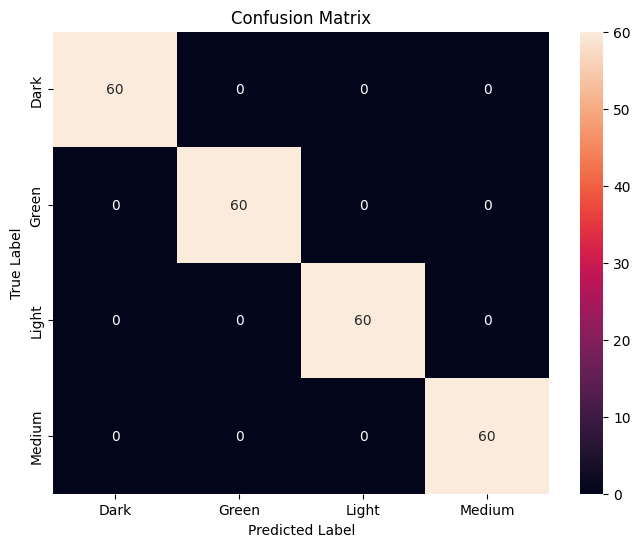

In [200]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_vit, preds_vit)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Прогон на тестовой выборке, фиксирование результатов

In [206]:
def score(model, test_dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return f1_score(all_labels, all_preds, average='weighted')


test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=baseline_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [207]:
m1 = score(convolutional_model, test_dataloader)
m2 = score(transformer_model, test_dataloader)
m3 = score(convolutional_model_improved, test_dataloader)
m4 = score(improved_model_vit, test_dataloader)

In [208]:
print(m1)
print(m2)
print(m3)
print(m4)

0.3985241697552645
0.9623083850736767
0.9974999374984376
1.0


## 4.	Имплементация алгоритма

Сначала реализуем свою сверточную модель

In [210]:
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=baseline_transform)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4),
}

In [211]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((7,7)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [212]:
model_custom = CNN(4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_custom, preds, true_labels = train_model(model_custom, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation F1 Score: {val_f1:.4f}')

Epoch 1/10
----------
train | Loss: 1.3895  F1:  0.2004
val   | Loss: 1.3558  F1:  0.2269

Epoch 2/10
----------
train | Loss: 1.3085  F1:  0.3325
val   | Loss: 1.2698  F1:  0.4843

Epoch 3/10
----------
train | Loss: 1.2442  F1:  0.4649
val   | Loss: 1.2037  F1:  0.7160

Epoch 4/10
----------
train | Loss: 1.1936  F1:  0.5544
val   | Loss: 1.1451  F1:  0.8008

Epoch 5/10
----------
train | Loss: 1.1394  F1:  0.6027
val   | Loss: 1.0911  F1:  0.8359

Epoch 6/10
----------
train | Loss: 1.0918  F1:  0.6676
val   | Loss: 1.0405  F1:  0.8702

Epoch 7/10
----------
train | Loss: 1.0347  F1:  0.7257
val   | Loss: 0.9934  F1:  0.8955

Epoch 8/10
----------
train | Loss: 1.0045  F1:  0.7473
val   | Loss: 0.9893  F1:  0.9082

Epoch 9/10
----------
train | Loss: 1.0092  F1:  0.7300
val   | Loss: 0.9852  F1:  0.9040

Epoch 10/10
----------
train | Loss: 0.9997  F1:  0.7625
val   | Loss: 0.9793  F1:  0.8912

Validation F1 Score: 0.9082


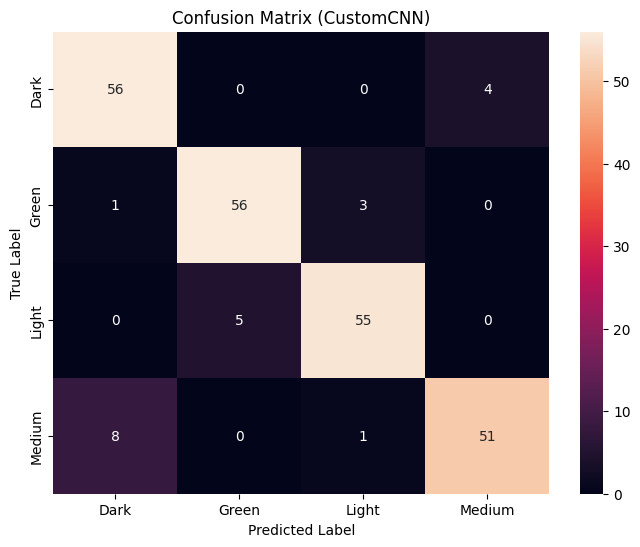

In [214]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.title('Confusion Matrix (CustomCNN)')
plt.show()

In [215]:
class SimpleViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 embed_dim=256,
                 depth=6,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=10,
                 dropout=0.1):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(
            in_chans, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1+num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.patch_embed.weight, std=0.02)
        nn.init.zeros_(self.patch_embed.bias)

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)       
        x = x.flatten(2).transpose(1,2) 

        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat([cls_tokens, x], dim=1)

        x = x + self.pos_embed
        x = self.dropout(x)

        x = x.transpose(0,1) 
        x = self.encoder(x)
        x = x.transpose(0,1)

        cls_final = x[:,0]
        return self.mlp_head(cls_final)

In [216]:
model_vit_custom = SimpleViT(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_dim=512,
    num_classes=4
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vit_custom.parameters(), lr=3e-5, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_vit_custom, preds_vit_c, labels_vit_c = train_model(model_vit_custom, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

val_f1 = f1_score(labels_vit_c, preds_vit_c, average='weighted')
print(f'Validation F1 Score Transform model: {val_f1:.4f}')

Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


train | Loss: 1.3852  F1:  0.2646
val   | Loss: 1.3433  F1:  0.2933

Epoch 2/10
----------
train | Loss: 1.3311  F1:  0.4026
val   | Loss: 1.2918  F1:  0.4917

Epoch 3/10
----------
train | Loss: 1.2816  F1:  0.4967
val   | Loss: 1.2375  F1:  0.6565

Epoch 4/10
----------
train | Loss: 1.2268  F1:  0.5801
val   | Loss: 1.1836  F1:  0.6800

Epoch 5/10
----------
train | Loss: 1.1762  F1:  0.5808
val   | Loss: 1.1190  F1:  0.7266

Epoch 6/10
----------
train | Loss: 1.1158  F1:  0.6178
val   | Loss: 1.0606  F1:  0.7267

Epoch 7/10
----------
train | Loss: 1.0478  F1:  0.6992
val   | Loss: 1.0047  F1:  0.7391

Epoch 8/10
----------
train | Loss: 1.0277  F1:  0.6811
val   | Loss: 0.9992  F1:  0.7279

Epoch 9/10
----------
train | Loss: 1.0177  F1:  0.6718
val   | Loss: 0.9930  F1:  0.7429

Epoch 10/10
----------
train | Loss: 1.0129  F1:  0.6859
val   | Loss: 0.9882  F1:  0.7519

Validation F1 Score Transform model: 0.7519


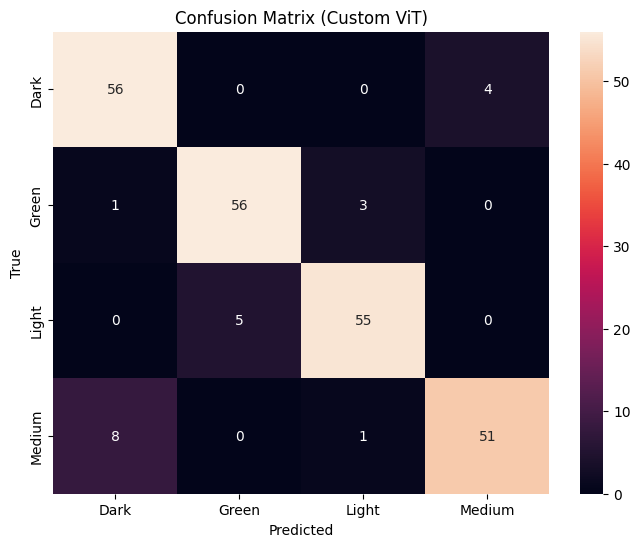

In [218]:
cm_custom_vit = confusion_matrix(labels_vit_c, preds_vit_c)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Custom ViT)')
plt.show()

**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [219]:
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=improved_transforms_train)
val_dataset_full   = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=baseline_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
}

In [220]:
model_cnn_imp = CNN(4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_cnn_imp.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_cnn_imp, preds_cnn_imp, labels_cnn_imp = train_model(model_cnn_imp, criterion, optimizer, scheduler, num_epochs=10)

val_f1_improved = f1_score(labels_cnn_imp, preds_cnn_imp, average='weighted')
print(f'Validation F1 Score (Improved): {val_f1_improved:.4f}')

Epoch 1/10
----------
train | Loss: 1.1945  F1:  0.5807
val   | Loss: 0.3816  F1:  0.9833

Epoch 2/10
----------
train | Loss: 0.5821  F1:  0.7585
val   | Loss: 0.2472  F1:  0.9497

Epoch 3/10
----------
train | Loss: 0.5228  F1:  0.8033
val   | Loss: 0.2928  F1:  0.8824

Epoch 4/10
----------
train | Loss: 0.4437  F1:  0.8314
val   | Loss: 0.2991  F1:  0.8773

Epoch 5/10
----------
train | Loss: 0.3829  F1:  0.8409
val   | Loss: 0.1285  F1:  0.9666

Epoch 6/10
----------
train | Loss: 0.3796  F1:  0.8624
val   | Loss: 0.2521  F1:  0.9052

Epoch 7/10
----------
train | Loss: 0.3585  F1:  0.8768
val   | Loss: 0.1112  F1:  0.9669

Epoch 8/10
----------
train | Loss: 0.3462  F1:  0.8579
val   | Loss: 0.1951  F1:  0.9248

Epoch 9/10
----------
train | Loss: 0.3425  F1:  0.8727
val   | Loss: 0.2016  F1:  0.9254

Epoch 10/10
----------
train | Loss: 0.3269  F1:  0.8827
val   | Loss: 0.2200  F1:  0.9093

Validation F1 Score (Improved): 0.9833


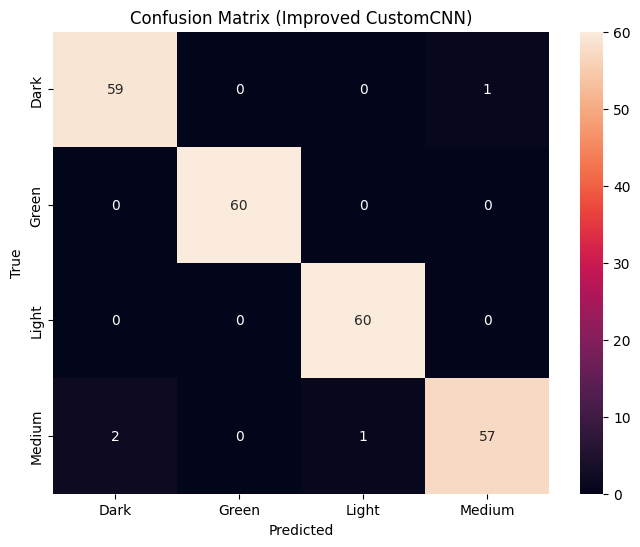

In [221]:
cm = confusion_matrix(labels_cnn_imp, preds_cnn_imp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.title('Confusion Matrix (Improved CustomCNN)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

In [222]:
model_vit_imp = SimpleViT(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_dim=512,
    num_classes=4
).to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit_imp.parameters(), lr=3e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_vit_imp, preds_vit_imp, labels_vit_imp = train_model(model_vit_imp, criterion, optimizer, scheduler, num_epochs=10)

f1_vit  = f1_score(labels_vit_imp, preds_vit_imp, average='weighted')
print(f'Validation F1 Score   (ViT): {f1_vit:.4f}')

Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


train | Loss: 1.0191  F1:  0.5592
val   | Loss: 0.7532  F1:  0.7670

Epoch 2/10
----------
train | Loss: 0.8013  F1:  0.6796
val   | Loss: 0.5615  F1:  0.7843

Epoch 3/10
----------
train | Loss: 0.6501  F1:  0.7390
val   | Loss: 0.6419  F1:  0.7219

Epoch 4/10
----------
train | Loss: 0.6390  F1:  0.7516
val   | Loss: 0.4565  F1:  0.8559

Epoch 5/10
----------
train | Loss: 0.5880  F1:  0.7648
val   | Loss: 0.5369  F1:  0.7111

Epoch 6/10
----------
train | Loss: 0.5668  F1:  0.7774
val   | Loss: 0.4521  F1:  0.8581

Epoch 7/10
----------
train | Loss: 0.5537  F1:  0.7982
val   | Loss: 0.3136  F1:  0.9191

Epoch 8/10
----------
train | Loss: 0.4929  F1:  0.8025
val   | Loss: 0.2718  F1:  0.9222

Epoch 9/10
----------
train | Loss: 0.4922  F1:  0.8118
val   | Loss: 0.2597  F1:  0.9316

Epoch 10/10
----------
train | Loss: 0.4676  F1:  0.8304
val   | Loss: 0.2434  F1:  0.9448

Validation F1 Score   (ViT): 0.9448


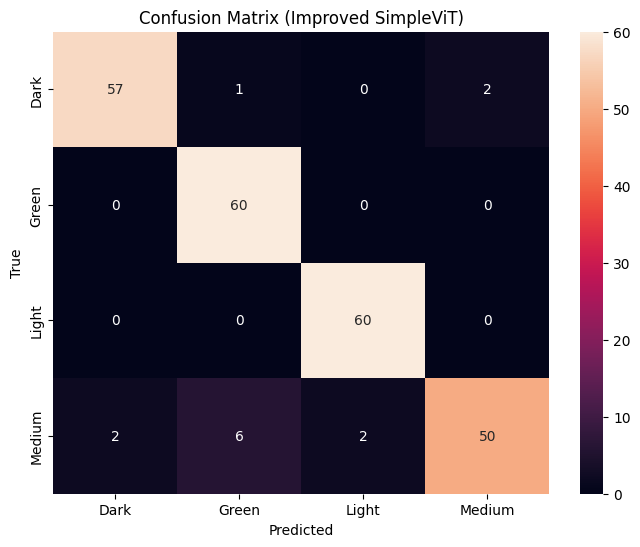

In [224]:
cm = confusion_matrix(labels_vit_imp, preds_vit_imp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.title('Confusion Matrix (Improved SimpleViT)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

## Прогон на тестовой выборке, фиксирование результатов

In [206]:
def score(model, test_dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return f1_score(all_labels, all_preds, average='weighted')


test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=baseline_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [225]:
conv_base_model = score(convolutional_model, test_dataloader)
vit_base_model = score(transformer_model, test_dataloader)
conv_upgrade_model = score(convolutional_model_improved, test_dataloader)
vit_upgrade_model = score(improved_model_vit, test_dataloader)
conv_base_imp_model = score(model_custom, test_dataloader)
vit_base_imp_model = score(model_vit_custom, test_dataloader)
conv_upgrade_imp_model = score(model_cnn_imp, test_dataloader)
vit_upgrade_imp_model = score(model_vit_imp, test_dataloader)

In [228]:
print(f'Сверточная модель: {conv_base_model}')
print(f'Трансформер модель: {vit_base_model}')
print(f'Сверточная улучшенная модель: {conv_upgrade_model}')
print(f'Трансформер улучшенная модель: {vit_upgrade_model}')
print(f'Сверточная собственная модель: {conv_base_imp_model}')
print(f'Трансформер собственная модель: {vit_base_imp_model}')
print(f'Сверточная собственная улучшенная модель: {conv_upgrade_imp_model}')
print(f'Трансформер собственная улучшенная модель: {vit_upgrade_imp_model}')

Сверточная модель: 0.3985241697552645
Трансформер модель: 0.9623083850736767
Сверточная улучшенная модель: 0.9974999374984376
Трансформер улучшенная модель: 1.0
Сверточная собственная модель: 0.9071144954983293
Трансформер собственная модель: 0.7644159453639854
Сверточная собственная улучшенная модель: 0.9674717471747174
Трансформер собственная улучшенная модель: 0.9493753541587217


# Вывод:

В ходе выполнения работы можно выявить превосходство трансформеров в решении задачи классификации изображений. Также важно отметить роль аугментаций и подбора гиперпараметров, что значительно улучшает качество обоих типов моделей. Собственные имплементации алгоритмов по большей части работают хуже, чем модели из коробки. Скорее всего это связано с неэффективной реализацией и упущениями в архитектуре, которые проявляют себя в мЕньших значениях получаемых метрик.